# Lab 5-6
## Prykhodko Andrii & Shakhova Kate

In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
import nltk 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
dataset = 'mail_data.csv'

In [3]:
data = pd.read_csv(dataset)

In [4]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data_to_clear = data['Message'].values

In [6]:
nltk.download('stopwords')
stop_words = stopwords.words("english")

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub("@\S+", " ", text)
    text = re.sub("https*\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub("\d", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\s{2,}',' ', text)
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text

In [8]:
clean_data = []

In [9]:
for text in data_to_clear:
     clean_data.append(clean_text(text))

In [10]:
data['Message']=clean_data

In [11]:
data.head()

,Category,Message
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts st ...
3,ham,u dun say early hor u c already say
4,ham,nah think goes usf lives around though


In [12]:
data['Category'] = data['Category'].map({'spam':1, 'ham': 0})

In [13]:
data.head()

,Category,Message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun say early hor u c already say
4,0,nah think goes usf lives around though


In [14]:
X = data["Message"]
y = data["Category"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
vectorizer = TfidfVectorizer()
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

## MNB classifier

In [17]:
from sklearn.tree import DecisionTreeClassifier #CART

DT_classifier = DecisionTreeClassifier()#створимо класифікатор дерева рішень, що працює на основі CART
DT_classifier.fit(X_train_features, y_train)#вчимо класифікатор

DecisionTreeClassifier()

In [20]:
y_pred = DT_classifier.predict(X_test_features)#прогнозуємо тестові дані

print(classification_report(y_test,y_pred))# виводимо звіт класифікації

print('Accuracy of MNB classifier: {} %'.format(round(accuracy_score(y_test, y_pred) * 100),2))#виводимо загальну точність

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1475
           1       0.88      0.82      0.85       197

    accuracy                           0.97      1672
   macro avg       0.93      0.90      0.92      1672
weighted avg       0.97      0.97      0.97      1672

Accuracy of MNB classifier: 97 %


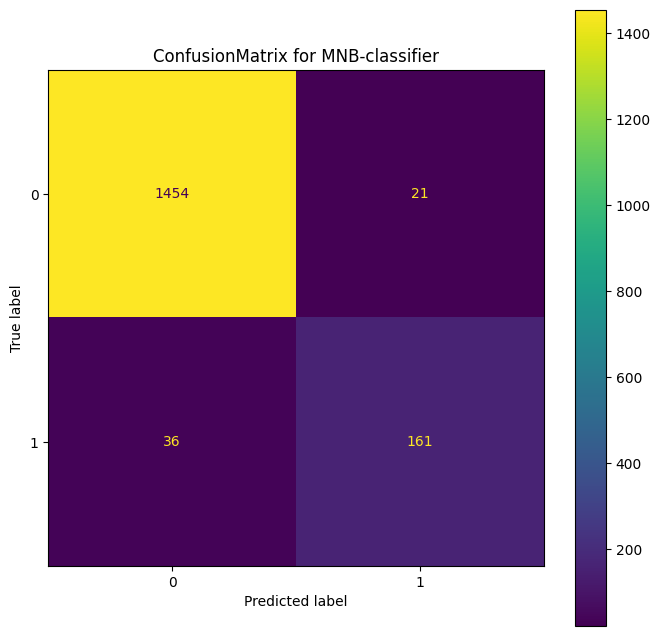

In [21]:
#побудуємо матрицю плутанини

plt.rcParams["figure.figsize"] = (8,8)

cm = confusion_matrix(y_test, y_pred, labels=DT_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=data.Category.unique())
disp.plot()
plt.title("ConfusionMatrix for MNB-classifier")

plt.show()

## DB Scan

In [22]:
vectorizer = TfidfVectorizer()#створимо векторизатор
X_features = vectorizer.fit_transform(X).toarray()#векторизуємо дані 

# Перетворимо всі дані у розмірність 2

from sklearn.decomposition import PCA 

pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_features) 

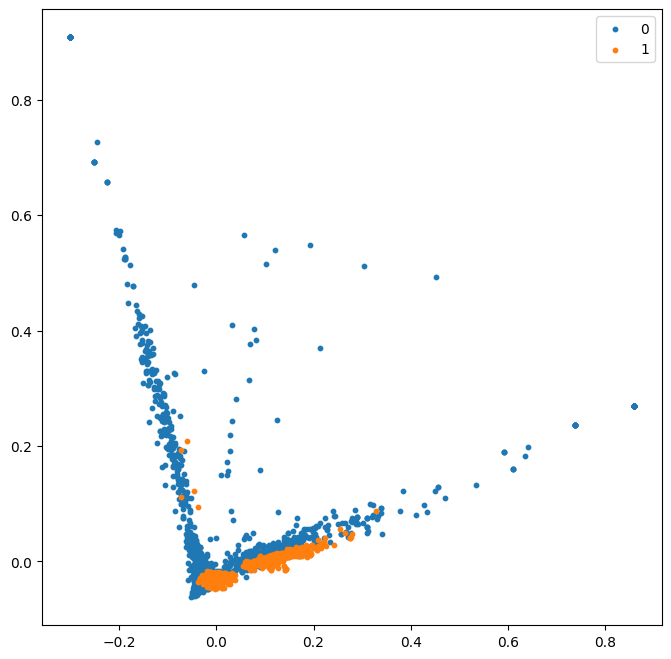

In [23]:
#Візуалізуємо розподіл точок у просторі


for i in data.Category.unique(): 
    plt.scatter(X_pca[data['Category'] == i, 0], 
                X_pca[data['Category'] == i, 1],  
                s=10, label = i) 
plt.legend() 
plt.show()

In [24]:
#Проводимо DBSCAN

# Створимо 2 моделі з різними параметрами та порівняємо їх, використовуючи А/В тестування
# Введемо нульову гіпотезу: Точність модельі 1 <= Точності моделі 2. Як метрику точності викоритаємо v_measure_score 
# Введемо гіпотезу 1: Точність модельі 2 <= Точності моделі 1

from sklearn.cluster import DBSCAN
from sklearn import metrics
from scipy.stats import ttest_ind

In [25]:
BUCKETS = 64 #Розмір пакету 

def get_v_measure_score(df):
    return metrics.v_measure_score(df['Spam_label'], df['model_A']),metrics.v_measure_score(df['Spam_label'], df['model_B'])

df = pd.DataFrame()
df['id'] = range(y.shape[0])
df['Spam_label'] = y.replace(1,-1) #бо DBSCAN повертає викиди як -1 (СПАМ)

#  модель 1
model_A = DBSCAN(eps=1, min_samples = 3)
model_A.fit(X_features)
df['model_A'] = model_A.labels_
df['model_A'] = df['model_A'].replace() 

#  модель 2
model_B = DBSCAN(eps=3, min_samples=5)
model_B.fit(X_features)
df['model_B'] = model_B.labels_


# рахуємо v_measure_score по бакетам
df['bucket'] = pd.util.hash_pandas_object(df['id'], index=False) % BUCKETS
tmp = df.groupby(['bucket']).apply(get_v_measure_score).reset_index().rename(columns={0:'v_measure_score'})

tmp[['v_measure_score_A', 'v_measure_score_B']] = tmp['v_measure_score'].tolist()
stat, p_val = ttest_ind(tmp['v_measure_score_B'], tmp['v_measure_score_A'], equal_var=False)

print('stat: ', stat, '\np_val:', round(p_val, 5))


/var/folders/_c/hfddj3lj4gg6_1zrnr5bsbb40000gp/T/ipykernel_2001/3576424259.py:14: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df['model_A'] = df['model_A'].replace()


stat:  -6.263532349885574 
p_val: 0.0


In [26]:
# Визначимо дані, які можуть бути спамом
spam_data = df[df['model_A'] == -1].shape[0]
print("Number of spam messages:", spam_data)

Number of spam messages: 729


In [27]:
# Визначимо дані, які можуть є спамом і розпізнані як спам
spam_data = df[(df['model_A']==-1) & (df['Spam_label']== -1)].shape[0]
print("Number of detected spam messages:", spam_data)

Number of detected spam messages: 74


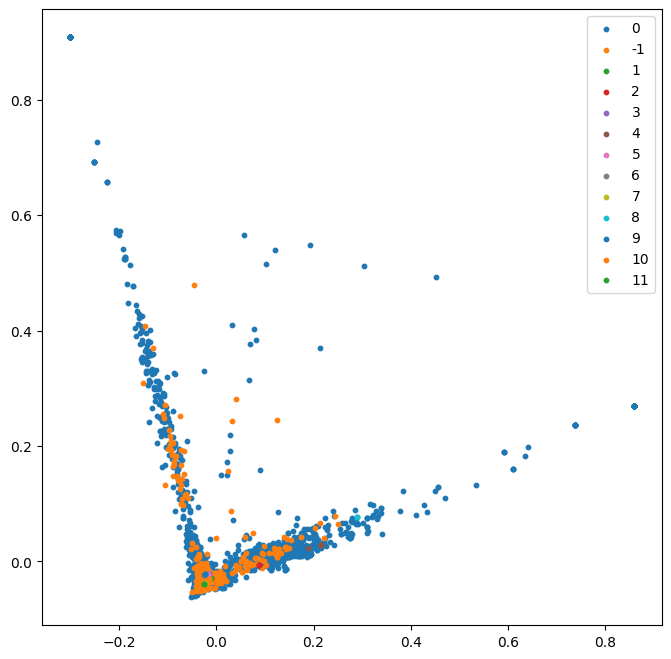

In [28]:
# візуалізуємо. -1 - це спам, інші кластери - якісь специфічні поідомлення (можливо одна теми ітд)

for i in df['model_A'].unique(): 
    plt.scatter(X_pca[df['model_A'] == i, 0], 
                X_pca[df['model_A'] == i, 1],  
                s=10, label = i) 
plt.legend() 
plt.show()